In [1]:
import pandas as pd
import numpy as np
import numpy.random as nr
from numpy.random import seed 
import matplotlib.pyplot as plt 
import seaborn as sns
from glob import glob
from pathlib import Path
import cv2
import keras
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, Model, load_model
#from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D 
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


# New section

In [ ]:
def templatematching(img,template):
    img_copy = img.copy()
    plt.imshow(img)
    h, w,channels = template.shape
    result = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
    threshold=0.67
    ############Segment of debug
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    ############ Try to find a way to get min max of the array and get the result from the rectangle, using minMaxLoc or other functions
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    bnd_res =cv2.rectangle(img_copy,top_left, bottom_right, 255, 10)
    plt.subplot(121)
    plt.imshow(result)
    plt.title('Result of Template Matching')
    plt.subplot(122)
    plt.imshow(bnd_res)
    plt.title('Detected Point')
    plt.show()
    print('\n')
    print('\n')
    #############
    if(max_val>threshold):
        counterstring = str(counter)
        filetype = '.jpg'
        filename = 'savedImage'
        filenamefinal = filename+counterstring+filetype
        cropped_image = img_copy[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
        cv2.imwrite(os.path.join(save_path,filenamefinal), cropped_image)
    
counter =0
##set paths for data extraction/import
extract_path = '/Users/donovanng/Documents/Code/Python/CNN/Edge/NOK/NOKRGB/'
save_path ='/Users/donovanng/Documents/Code/Python/CNN/Edge/Train/ProcessedNOK/'
#crop_img= cv2.imread('template.jpg')
##iterate through the folder consisting of the data and convert them to canny maps
for image_path in os.listdir(extract_path):
    input_path = os.path.join(extract_path, image_path)
    img = cv2.imread(input_path)
    if img is None:
        sys.exit("Could not show image")
    crop_img= cv2.imread('/Users/donovanng/Documents/Code/Python/CNN/Edge/Template/template.jpg')
    crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
    templatematching(img,crop_img)
    counter+=1

NameError: name 'os' is not defined

In [3]:
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 1000

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
train_datagen = ImageDataGenerator( rescale=1./255, #Feature scaling
        rotation_range=5,
        shear_range=0.05, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, fill_mode='nearest',)
training_set = train_datagen.flow_from_directory(
                '/content/drive/MyDrive/Starter-Project/Updated_train_test/Train',
#input your own filepath here
target_size=(331,331), #each model has different target size.Input accordingly
                batch_size=BATCH_SIZE,
                class_mode= 'categorical')
 

Found 1400 images belonging to 2 classes.


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
val_datagen = ImageDataGenerator(rescale=1./255) 
val_set = val_datagen.flow_from_directory(
'/content/drive/MyDrive/Starter-Project/Updated_train_test/Validate', #input your filepath here
target_size=(331,331), #each model has different target size. Input accordingly
                batch_size=BATCH_SIZE,
                class_mode='categorical')

Found 69 images belonging to 2 classes.


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
test_datagen = ImageDataGenerator(rescale=1./255) 
test_set = test_datagen.flow_from_directory(
'/content/drive/MyDrive/Starter-Project/Updated_train_test/Test', # input your filepath here
target_size=(331,331), #each model has different target size. Input accordingly
batch_size=BATCH_SIZE, class_mode='categorical',shuffle=False)

Found 50 images belonging to 2 classes.


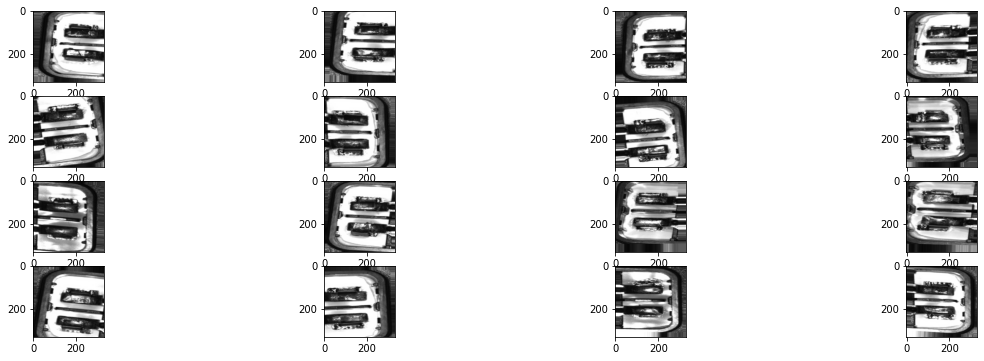

In [7]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20,6))
for i in range(16): 
   plt.subplot(4,4,i+1) 
   plt.imshow(training_set[0][0][i])
plt.show()

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import NASNetLarge
base_model = tf.keras.applications.NASNetLarge(weights='imagenet', include_top=False,input_shape=(331,331,3))


343621632/343610240 [==============================] - 4s 0us/step


In [9]:

for layer in base_model.layers: 
  layer.trainable = False

In [10]:
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 165, 165, 96  2592        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 165, 165, 96  384         ['stem_conv1[0][0]']             
                                )                                                            

In [11]:
x = base_model.output # Add pooling layer
x = GlobalAveragePooling2D()(x)
# Add 2 fully connected layers
x = Dense(512, activation='relu')(x) #change it if you know how to makeit optimal
x = Dense(128, activation='relu')(x) # Add output layer
predictions = Dense(2, activation='softmax')(x)

In [12]:
model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
opt = tf.keras.optimizers.Adam(epsilon = 1.0)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics =
'accuracy')

In [14]:
filepath = '/content/drive/MyDrive/Starter-Project/CNN/models/model2NAS.hdf5' # define where the model is saved. Format is .hdf5
callbacks_list = [
tf.keras.callbacks.EarlyStopping
(
monitor = 'val_loss', # Use validation loss to monitor the model
verbose=1,
patience = 4 # Stop after 3 epochs with no improvements in vali dation loss
    ),
tf.keras.callbacks.ModelCheckpoint(
filepath = filepath, # file where the checkpoint is saved monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
verbose=1,
save_best_only = True # Only save model if it is the best 
)
]
nr.seed(1234)
history = model.fit(training_set, steps_per_epoch=1400//32,
                                           validation_data=val_set,
                                           validation_steps=69//16,
                                           epochs=30, verbose=1,
                                           callbacks = callbacks_list)

Epoch 1/30
43/43 [==============================] - ETA: 0s - loss: 0.6975 - accuracy: 0.5058 
Epoch 00001: val_loss improved from inf to 0.64183, saving model to /content/drive/MyDrive/Starter-Project/CNN/models/model2NAS.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


43/43 [==============================] - 752s 17s/step - loss: 0.6975 - accuracy: 0.5058 - val_loss: 0.6418 - val_accuracy: 0.5781
Epoch 2/30
43/43 [==============================] - ETA: 0s - loss: 0.6854 - accuracy: 0.5422 
Epoch 00002: val_loss improved from 0.64183 to 0.63892, saving model to /content/drive/MyDrive/Starter-Project/CNN/models/model2NAS.hdf5
43/43 [==============================] - 720s 17s/step - loss: 0.6854 - accuracy: 0.5422 - val_loss: 0.6389 - val_accuracy: 0.5625
Epoch 3/30
43/43 [==============================] - ETA: 0s - loss: 0.6700 - accuracy: 0.6162 
Epoch 00003: val_loss improved from 0.63892 to 0.62489, saving model to /content/drive/MyDrive/Starter-Project/CNN/models/model2NAS.hdf5
43/43 [==============================] - 713s 17s/step - loss: 0.6700 - accuracy: 0.6162 - val_loss: 0.6249 - val_accuracy: 0.5938
Epoch 4/30
43/43 [==============================] - ETA: 0s - loss: 0.6440 - accuracy: 0.6971 
Epoch 00004: val_loss improved from 0.62489 to 0

In [17]:

## load the model
from tensorflow.keras.preprocessing import image
import numpy 
model = load_model('/content/drive/MyDrive/Starter-Project/CNN/models/model2NAS.hdf5')
#dictionary to label all 4 dataset classes.
classes = { 
    0:'OK',
    1:'NOK',
     
}
##def batch size
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 1000

##def the test set
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
test_datagen = ImageDataGenerator(rescale=1./255) 
test_set = test_datagen.flow_from_directory(
'/content/drive/MyDrive/Starter-Project/Updated_train_test/Test', # input your filepath here
target_size=(331,331), #each model has different target size. Input accordingly
batch_size=BATCH_SIZE, class_mode='categorical',shuffle=False)

##single prediction
import numpy as np
test_image = image.load_img('/content/drive/MyDrive/Starter-Project/Updated_train_test/Test/OK/1_20211210110722.jpeg975.jpg', target_size = (331, 331))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image/255.0)
if result[0][0] <= 0.5:
  prediction = 'OK'
else:
  prediction = 'NOK'
print(prediction)

##evaluate on test set
model.evaluate(test_set,steps=50//16,verbose=1)

Found 50 images belonging to 2 classes.
OK


KeyboardInterrupt: ignored

In [ ]:
# summarize history for accuracy plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('NASNetLarge Final Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

NameError: name 'history' is not defined

In [ ]:
# summarize history for loss plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('NASNetLarge Final Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

NameError: name 'history' is not defined

In [ ]:
pred = model.predict(test_set, steps=50//16, verbose=1) 
predicted_class_indices=np.argmax(pred,axis=1)
labels = (test_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

NameError: name 'model' is not defined

In [ ]:
report = classification_report(test_set.classes, predicted_class_indices,
                                        target_names=['OK', 'NOK'])
print(report)

NameError: name 'test_set' is not defined

In [ ]:
sns.heatmap(
confusion_matrix(test_set.classes, predicted_class_indices), annot=True,
fmt="d",
cbar = False,
cmap = plt.cm.Blues
)

In [ ]:
from tensorflow.keras.preprocessing import image
from PIL import ImageTk, Image
import numpy 

from keras.models import load_model
model = load_model('/model/modelNAS.hdf5')

#dictionary to label all 4 dataset classes.
classes = { 
    0:'OK',
    1:'NOK',
     
}

ImportError: libtk8.6.so: cannot open shared object file: No such file or directory

In [ ]:
def predict(file_path):
    test_image = image.load_img(file_path ,target_size=(212,212))
    test_image = image.img_to_array(test_image)
    test_image = numpy.expand_dims(test_image,axis=0)
    pred = model.predict(test_image)
    print('Pred:')
    
    pred = numpy.around(pred)
    if pred <= 0.5:
        return 'OK'
    elif pred > 0.5:
        return 'NOK'

In [ ]:
def predictImage(filename):
    img1 = image.load_img(filename ,target_size=(331,331,3))
    plt.imshow(img1)
    Y = image.img_to_array(img1) 
    X = np.expand_dims(Y,axis=0)
    X = X/255
    val = model.predict(X)
    val = np.argmax(val, axis=1)
    print(val)
    if val <=  0.5:        
        plt.xlabel("OK",fontsize=30)
    elif val >0.5:        
        plt.xlabel("NOK",fontsize=30)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=38f78faa-b6a4-488f-b67a-02265a5e4f1a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>